In [1]:
import bolift
import pandas as pd
import numpy as np

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# RF baseline

## Experiment outputs

In [ ]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

In [ ]:
index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-3]
features, labels


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )

    X_train, y_train = train
    X_test, y_test = test
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

models = {}
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(len(train_df), len(test_df))
for i, k in enumerate(labels):
    # print(k, i, labels[i])
    train = (train_df[features], train_df[labels[i]])
    test = (test_df[features], test_df[labels[i]])
    models[k] = train_model(train, test)
    

In [ ]:
k = 11
sample = test_df.iloc[k:k+1]
feats = sample[features]
labs = sample[labels]

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

for k in labels:
    # print(k, rmse(models[k].predict(feats), labs[k].values))
    print(k, models[k].predict(feats), labs[k].values)

w = [float(a) for a in sample.iloc[0]['Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample.iloc[0]['Fluorescence_norm'][1:-1].split(',')]

plt.figure(figsize=(6, 4))
plt.plot(w, i, color="C0")
plt.title(f"{sample.iloc[0]['Experiment']}: {sample.iloc[0]['Temperature(C)']}°C, {sample.iloc[0]['Doping(%)']}%, {sample.iloc[0]['Time(min)']}min")
plt.axvline(x = models['Peak1'].predict(sample[features]), color = 'C1', linestyle = '--')
plt.axvline(x = models['Peak2'].predict(sample[features]), color = 'C3', linestyle = '--')
# change plt figsize
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized fluorescence")
plt.tight_layout()
plt.show()

## Spectra output

In [ ]:
df = pd.read_csv('Data/spectra_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

In [ ]:
index = df.keys().tolist().index('Experiment')
features = list(df.keys()[:index]) + ['Wavelength(nm)']
labels = ['Fluorescence_norm']
features, labels

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )
    
    X_train, y_train = train[train.columns.difference(['Fluorescence', 'Fluorescence_norm'])], train['Fluorescence_norm']
    X_test, y_test = test[test.columns.difference(['Fluorescence', 'Fluorescence_norm'])], test['Fluorescence_norm']
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

def test_model(model, validation):
    val_feats = validation[validation.columns.difference(['Fluorescence', 'Fluorescence_norm'])]
    val_labels = validation["Fluorescence_norm"]

    pred = model.predict(val_feats)
    return (pred, val_labels.to_numpy(), val_feats['Wavelength(nm)'].to_numpy())

In [ ]:
one_out = []
i=0
for group, validation in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    data = df.copy()
    exp, T, d, t = group
    validation = validation[features + labels]

    # validation = data.query(
    #     f'`Temperature(C)` == {T} & `Doping(%)` == {d} & `Time` == {t}'
    # )
    train_df = data.drop(validation.index)
    train, test = train_test_split(train_df[features + labels], test_size=0.2, random_state=42)

    model = train_model(train, test)

    prediction = test_model(model, validation)
    one_out.append((group, prediction))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i=0
for group, predictions in one_out:
    axs = axs.flatten()
    exp, T, d, t = group
    if exp not in ["8_NPL-13_(3-8-23)", "7_NPL-12_(3-8-23)"] or T != 0.0 or t != 60:
        continue
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    title = f"Doping: {d}%"

    if i == 0:
        axs[i].plot(predictions[2], predictions[0], color="C0", label='Prediction')
        axs[i].plot(predictions[2], predictions[1], color="C1", label='labels')
    else:
        axs[i].plot(predictions[2], predictions[0], color="C0")
        axs[i].plot(predictions[2], predictions[1], color="C1")
    axs[i].set_title(title)

    i+=1 
    plt.savefig(f'preds/{group}.png')
fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
fig.suptitle(f"7_NPL-12_(3-8-23) and 8_NPL-13_(3-8-23): T: 25 ºC, Time: 60 min")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update(
    {
        "figure.figsize": (5.0, 5.0 / 1.2),
    }
)

for group, predictions in one_out:
    exp, T, d, t = group
    title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    plt.figure()
    sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction').set(title=title)
    sns.lineplot(x=predictions[2], y=predictions[1], label='label')
    plt.legend()
    plt.savefig(f'preds/{group}.png')
    fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
    plt.show()



### Evaluate predictions

In [ ]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [ ]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

pred_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}
label_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}

for group, predictions in one_out:
    pred_peak = get_peaks(predictions[2], predictions[0])
    pred_norm_area = get_area_under_peaks(predictions[2], predictions[0])
    pred_area = get_area_under_peaks(predictions[2], predictions[0], norm=pred_norm_area)

    label_peak = get_peaks(predictions[2], predictions[1])
    label_norm_area = get_area_under_peaks(predictions[2], predictions[1])
    label_area = get_area_under_peaks(predictions[2], predictions[1], norm=label_norm_area)
    
    pred_dict["Peak1"].append(pred_peak[0])
    pred_dict["Peak2"].append(pred_peak[1])
    pred_dict["Area1"].append(pred_area[0])
    pred_dict["Area2"].append(pred_area[1])
    pred_dict["Distance_peaks"].append(pred_peak[1] - pred_peak[0])

    label_dict["Peak1"].append(label_peak[0])
    label_dict["Peak2"].append(label_peak[1])
    label_dict["Area1"].append(label_area[0])
    label_dict["Area2"].append(label_area[1])
    label_dict["Distance_peaks"].append(label_peak[1] - label_peak[0])
    
    #plot
    # exp, T, d, t = group
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    # plt.figure()
    # sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction').set(title=title)
    # sns.lineplot(x=predictions[2], y=predictions[1], label='label')
    # plt.legend()
    # plt.show()    

for k in pred_dict.keys():
    print(k, rmse(np.array(pred_dict[k]), np.array(label_dict[k])))

# bolift

In [3]:
import os
import cloudpickle
import bolift
import seaborn as sns
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [4]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

Dimension1(nm)  \
Experiment            Temperature(C) Doping(%) Time(min)                   
1_NPL-4_(5-31-22)     25             1.25      60                      1   
                                     2.50      60                      1   
                                     5.00      60                      1   
                                     10.00     60                      1   
2_NPL-4_(6-1-22)      25             0.25      60                      1   
                                     0.50      60                      1   
                                     0.75      60                      1   
                                     1.00      60                      1   
                                     1.25      60                      1   
                                     1.50      60                      1   
                                     1.75      60                      1   
                                     2.00      60                      1   
                                     3.00      60                      1   
3_NPL-11_(12-26-22)   25             0.50      60                      1   
                                     1.00      60                      1   
                                     2.00      60                      1   
                                     3.00      60                      1   
                                     5.00      60                      1   
4_NPL-17_(5-3-23)     25             0.50      60                      1   
                                     0.75      60                      1   
                                     1.00      60                      1   
                                     5.00      60                      1   
5_NPL-17_(5-22-23)    25             0.25      60                      1   
                                     0.50      60                      1   
                                     1.00      60                      1   
                                     5.00      60                      1   
6_NPL-6_C.L._(7-7-23) 25             0.50      60                      1   
                                     5.00      60                      1   
7_NPL-12_(3-8-23)     0              3.00      10                      1   
                                               60                      1   
                                     10.00     10                      1   
                                               60                      1   
                      25             3.00      10                      1   
                                               60                      1   
                                               180                     1   
                                     10.00     10                      1   
                                               60                      1   
                                               180                     1   
                      50             3.00      10                      1   
                                               60                      1   
                                     10.00     10                      1   
                                               60                      1   
8_NPL-13_(3-8-23)     0              1.00      10                      1   
                                               60                      1   
                                     5.00      10                      1   
                                               60                      1   
                      25             1.00      10                      1   
                                               60                      1   
                                               180                     1   
                                     5.00      10                      1   
                                               60                      1   
                              

In [5]:
index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-3]
features, labels

(Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
        'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
        'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)'],
       dtype='object'),
 Index(['Peak1', 'Peak2', 'Area1', 'Area2', 'QY', 'Fl_Wavelengths',
        'Fluorescence', 'Fluorescence_norm'],
       dtype='object'))

In [6]:
prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

prompts = []
labels_auc1 = []
labels_auc2 = []
labels_qy   = []
labels_f    = []
for i, r in df.iterrows():
    if r['QY']*r['Area2'] < 0.0:
        continue
    s = r[features].to_dict()
    prompts.append(prompt_template.format(**s))
    labels_auc1.append(r['Area1'])
    labels_auc2.append(r['Area2'])
    labels_qy.append(r['QY'])
    labels_f.append(r['QY']*r['Area2'])

examples = [f"{p}\t{a1}\t{a2}\t{qy}\t{f}" for p, a1, a2, qy, f in zip(prompts, labels_auc1, labels_auc2, labels_qy, labels_f)]

with open('Data/procedures.tsv', 'w') as f:
    f.write(f"prompt\tauc1\tauc2\tQY\tobj_f\n")
    f.write('\n'.join(examples))

In [7]:
import numpy as np
indexes = np.arange(len(prompts))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

train_indexes = indexes[:int(split*len(indexes))]
test_indexes = indexes[int(split*len(indexes)):]

### Testing prediction

In [67]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
  if labels_qy[i] >= 0:
    asktell.tell(prompts[i], labels_f[i])

In [74]:
yhat=[]
y=[]
for i in test_indexes:
  yhat.append(asktell.predict(prompts[i]))
  y.append(labels_f[i])

In [75]:
for i in test_indexes:
  print(f"{prompts[i]} => {labels_qy[i]}")

[f"{i.mean():.2f}" for i in yhat], y

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175 %recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 0.0579425782072234
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12 %recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20 mL of MeOH and 8 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively.

(['0.04',
  '0.03',
  '0.04',
  '0.05',
  '0.02',
  '0.04',
  '0.06',
  '0.06',
  '0.03',
  '0.02',
  '0.04',
  '0.06'],
 [0.040937916481985095,
  0.07989831393725723,
  0.00681497182866864,
  0.07270174319092729,
  0.01883424585255875,
  0.04739196681802644,
  0.04565597808262177,
  0.03396130654934971,
  0.05050357809551086,
  0.030368143452159085,
  -0.3949212033452669,
  0.05945566629449056])

|        predicted        |   label    |     AE     | 
|    0.04   +/-   0.04    |    0.04    |    0.00    |
|    0.03   +/-   0.01    |    0.08    |    0.05    |
|    0.04   +/-   0.01    |    0.01    |    0.03    |
|    0.05   +/-   0.01    |    0.07    |    0.02    |
|    0.02   +/-   0.00    |    0.02    |    0.00    |
|    0.04   +/-   0.00    |    0.05    |    0.01    |
|    0.06   +/-   0.01    |    0.05    |    0.01    |
|    0.06   +/-   0.00    |    0.03    |    0.02    |
|    0.03   +/-   0.00    |    0.05    |    0.02    |
|    0.02   +/-   0.04    |    0.03    |    0.01    |
|    0.04   +/-   0.02    |   -0.39    |    0.43    |
|    0.06   +/-   0.02    |    0.06    |    0.00    |

              RMSE: 0.13              


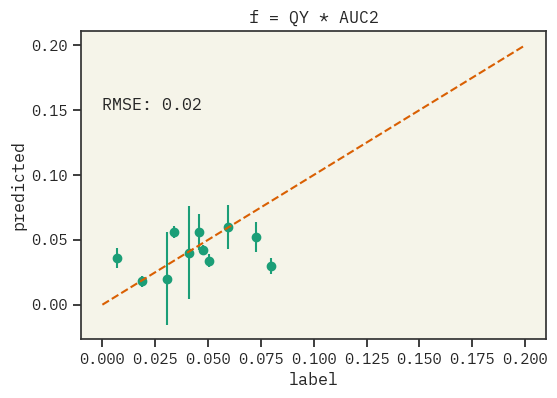

In [84]:
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
  n+=1
  mae = abs(ihat.mean()-i)
  print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
  sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

import matplotlib.pyplot as plt
y_plot    = np.array(y)[np.where(np.array(y) >= 0)]
yhat_plot = np.array([ihat.mean() for ihat in yhat])[np.where(np.array(y) >= 0)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(y) >= 0)]
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
plt.plot((0,0.2), (0,0.2), '--')
plt.text(0, 0.15, f"RMSE: {rmse(y_plot, yhat_plot):.2f}", fontsize=12)
plt.show()

### Bayesian optimization

In [26]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4",
    selector_k=5,
    temperature=0.7
)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))

In [27]:
max(labels_f)

0.17211522736299675

In [31]:
pool = cloudpickle.load(open('Data/pool_chunk.pkl', 'rb'))
selected = asktell.ask(pool, aq_fxn="expected_improvement", k=5, inv_filter=15, aug_random_filter=1)
selected

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Error in OpenAICallbackHandler.on_retry callback: 'OpenAICallbackHandler' object has no attribute 'on_retry'
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-4 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 40000 / min. Please try again in 1ms. Contact us through our help center at help.openai.com if you continue to have issues..
Error in OpenAICallbackHandler.on_retry callback: 'OpenAICallbackHandler' object has no attribute 'on_retry'


(['Stock nanoplatelets have dimensions 45.77 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 5.0 % Ag doping requires 15.1 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.',
  'Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 0.25 % Ag doping requires 0.75 uL of silver doping solution, respectively. The reaction w

In [29]:
selected

(['Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.',
  'Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.4 uL of silver doping solution, respectively. The reaction

In [30]:
asktell.predict(selected[0])

[GaussDist(0.09, 0.03320066164764364),
 DiscreteDist([0.08 0.09 0.14], [0.4 0.2 0.4]),
 DiscreteDist([0.03 0.07], [0.2 0.8]),
 DiscreteDist([0.07 0.08], [0.8 0.2]),
 DiscreteDist([0.02 0.06], [0.8 0.2])]